In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from itertools import product
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR

%matplotlib inline

In [4]:
# Read the data
df = pd.read_csv("covid_19_india.csv")
df2 = df
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [5]:
df.columns

Index(['Sno', 'Date', 'Time', 'State/UnionTerritory',
       'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured',
       'Deaths', 'Confirmed'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [7]:
# Checking for null values
df.isna().sum()

Sno                         0
Date                        0
Time                        0
State/UnionTerritory        0
ConfirmedIndianNational     0
ConfirmedForeignNational    0
Cured                       0
Deaths                      0
Confirmed                   0
dtype: int64

In [8]:
df = df.groupby('Date', as_index=False)['Deaths'].sum()

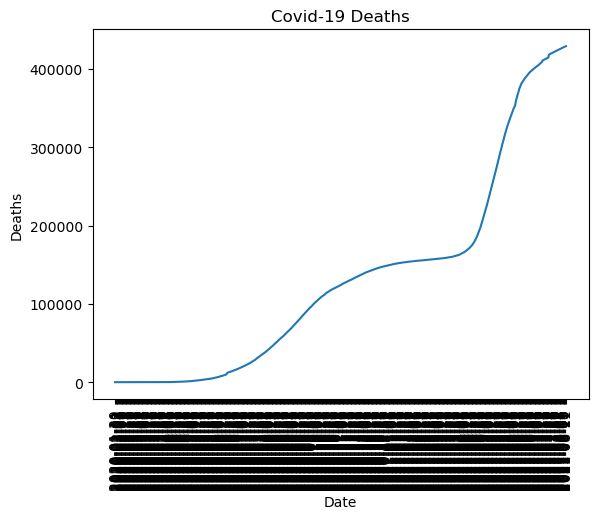

<Figure size 1200x600 with 0 Axes>

In [9]:
# Plotting the graph
plt.plot(df['Date'], df['Deaths'])
plt.title('Covid-19 Deaths')
plt.ylabel('Deaths')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.figure(figsize=(12, 6))
plt.show()

In [10]:
# ADF Test for Stationarity
ADF = adfuller(df['Deaths'])

print(f'ADF Statistic: {ADF[0]}')
print(f'p-value: {ADF[1]}')

ADF Statistic: 0.16789800070478134
p-value: 0.9704025118368168


In [11]:
df['death_tr_1'] = df['Deaths'].diff()

In [12]:
ADF = adfuller(df['death_tr_1'][1:])

print(f'ADF Statistic: {ADF[0]}')
print(f'p-value: {ADF[1]}')

ADF Statistic: -2.4515918577719304
p-value: 0.12770103279304423


In [13]:
df['death_tr_2'] = df['death_tr_1'].diff()

In [14]:
df.tail(9)

,Date,Deaths,death_tr_1,death_tr_2
551,2021-08-03,425195,422.0,0.0
552,2021-08-04,425757,562.0,140.0
553,2021-08-05,426290,533.0,-29.0
554,2021-08-06,426754,464.0,-69.0
555,2021-08-07,427371,617.0,153.0
556,2021-08-08,427862,491.0,-126.0
557,2021-08-09,428309,447.0,-44.0
558,2021-08-10,428682,373.0,-74.0
559,2021-08-11,429179,497.0,124.0


In [15]:
ADF = adfuller(df['death_tr_2'][2:])

print(f'ADF Statistic: {ADF[0]}')
print(f'p-value: {ADF[1]}')

ADF Statistic: -19.80603287273378
p-value: 0.0


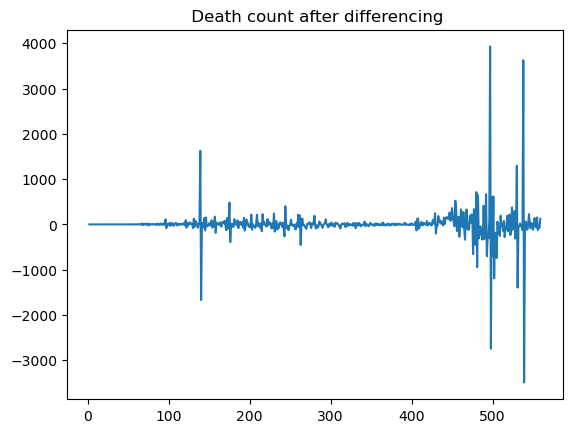

<Figure size 1200x600 with 0 Axes>

In [16]:
# Graph plot after differencing
plt.plot(df['death_tr_2'])
plt.title(" Death count after differencing")
plt.figure(figsize=(12, 6))
plt.show()

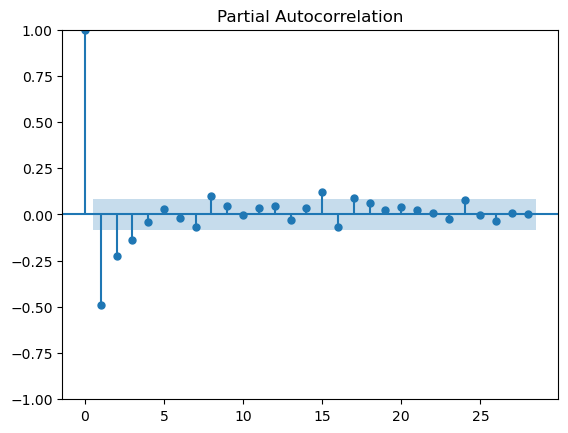

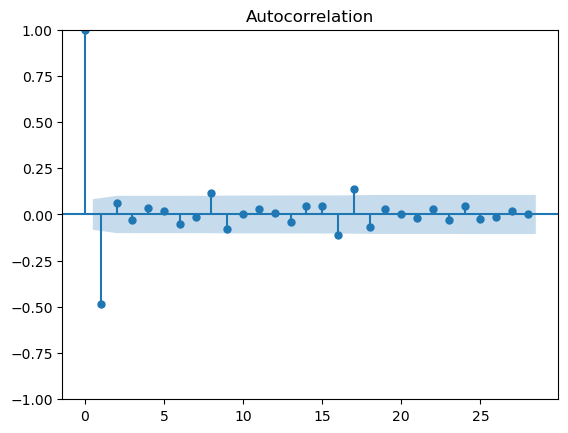

In [17]:
# Plot the ACF and PACF Graph
plot_pacf(df['death_tr_2'][2:]);
plot_acf(df['death_tr_2'][2:]);

In [18]:
# ARIMA Model
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC

        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=order).fit()
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [19]:
ps = range(0, 8, 1)
d = 2
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1,2)
    each = tuple(each)
    order_list.append(each)

order_list[:10]

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (1, 2, 0),
 (1, 2, 1)]

In [20]:
# Getting the order
result = optimize_ARIMA(df['death_tr_2'], order_list)
result

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(0, 2, 3)",7977.503977
1,"(0, 2, 4)",7978.239232
2,"(2, 2, 3)",7979.902962
3,"(0, 2, 5)",7979.956702
4,"(0, 2, 6)",7981.950190
...,...,...
59,"(3, 2, 0)",8545.106495
60,"(2, 2, 0)",8695.505647
61,"(0, 2, 1)",8753.775667
62,"(1, 2, 0)",8930.397876


In [21]:
model = ARIMA(df['death_tr_2'], order=(6,2,3))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:             death_tr_2   No. Observations:                  560
Model:                 ARIMA(6, 2, 3)   Log Likelihood               -4046.814
Date:                Sun, 15 Oct 2023   AIC                           8113.628
Time:                        15:58:17   BIC                           8156.872
Sample:                             0   HQIC                          8130.516
                                - 560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.6869      0.039    -69.443      0.000      -2.763      -2.611
ar.L2         -3.9437      0.087    -45.315      0.000      -4.114      -3.773
ar.L3         -3.6940      0.114    -32.269      0.0

<Figure size 1200x600 with 0 Axes>

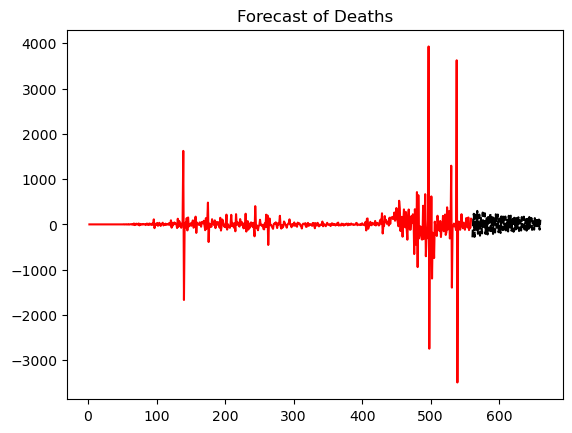

In [22]:
# Forecasting
plt.figure(figsize=(12, 6))
n_forecast = 100
predict = result.get_prediction(end=model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(df['death_tr_2'], 'red')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Deaths')
plt.show()

In [23]:
df['mean_death'] = predict.predicted_mean
df.tail(10)

,Date,Deaths,death_tr_1,death_tr_2,mean_death
550,2021-08-02,424773,422.0,-119.0,34.350978
551,2021-08-03,425195,422.0,0.0,-179.750083
552,2021-08-04,425757,562.0,140.0,243.147291
553,2021-08-05,426290,533.0,-29.0,-319.543866
554,2021-08-06,426754,464.0,-69.0,-24.639653
555,2021-08-07,427371,617.0,153.0,219.812377
556,2021-08-08,427862,491.0,-126.0,-290.262600
557,2021-08-09,428309,447.0,-44.0,270.040898
558,2021-08-10,428682,373.0,-74.0,21.168269
559,2021-08-11,429179,497.0,124.0,-186.784775


**MA Model**

In [24]:
# Fitting the MA model
order = 1
ma_model = ARIMA(df['death_tr_2'], order=(0, 2, order))
ma_fit = ma_model.fit()

In [25]:
print(ma_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             death_tr_2   No. Observations:                  560
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -4374.888
Date:                Sun, 15 Oct 2023   AIC                           8753.776
Time:                        15:58:18   BIC                           8762.424
Sample:                             0   HQIC                          8757.153
                                - 560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9997      0.294     -3.398      0.001      -1.576      -0.423
sigma2      3.728e+05    1.1e+05      3.383      0.001    1.57e+05    5.89e+05
Ljung-Box (L1) (Q):                 263.54   Jarque-

In [26]:
# Forecasting
forecast_steps = 730
forecast = ma_fit.forecast(steps=forecast_steps)
n_forecast = 3
predict = ma_fit.get_prediction(end=ma_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)
ma_death_mean = predict.predicted_mean

<Figure size 1200x600 with 0 Axes>

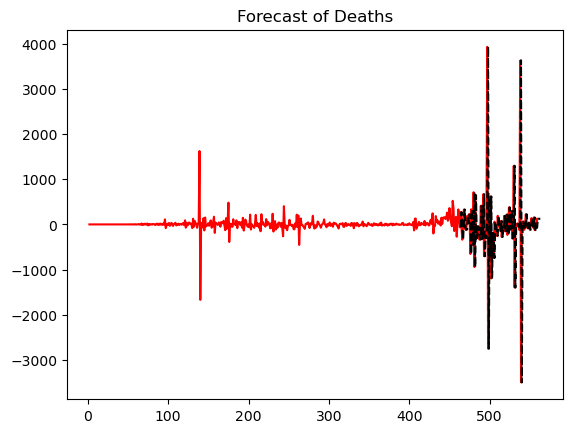

In [27]:
plt.figure(figsize=(12, 6))
n_forecast = 100
predict = result.get_prediction(end=ma_model.nobs + n_forecast)
idx = np.arange(len(ma_death_mean))

fig, ax = plt.subplots()
ax.plot(df['death_tr_2'], 'red')
ax.plot(idx[-n_forecast:], ma_death_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Deaths')
plt.show()

In [30]:
df2 = pd.read_csv('covid_19_india.csv')
df2 = df2.groupby('Date', as_index=False)['Cured'].sum()

df2["death_tr_2"] = df["death_tr_2"]

# CHECKING STATIONARITY FOR CURED 

In [31]:
ad_fuller_result_1 = adfuller(df2['Cured'])

print('Cured')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

Cured
ADF Statistic: 1.5871659199349608
p-value: 0.997818557036317


In [32]:
df2["cured_tr_1"] = df2["Cured"].diff()
df2.head()

,Date,Cured,death_tr_2,cured_tr_1
0,2020-01-30,0,NaN,NaN
1,2020-01-31,0,NaN,0.0
2,2020-02-01,0,0.0,0.0
3,2020-02-02,0,0.0,0.0
4,2020-02-03,0,0.0,0.0


In [56]:
def optimize_VAR(endog):
    """
        Returns a dataframe with parameters and corresponding MSE
        
        endog - observed time series
    """
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        mse = model.aic
        results.append([i, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'aic']
    
    result_df = result_df.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_df

In [57]:
ad_fuller_result_2 = adfuller(df2['cured_tr_1'][1:])

print('Cured')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Cured
ADF Statistic: -3.5372154706414496
p-value: 0.00708120754885506


In [58]:
endog = df2[['cured_tr_1', 'death_tr_2']]
result_df = optimize_VAR(endog)
result_df
 

  0%|          | 0/15 [00:00<?, ?it/s]

,p,aic
0,13,19364.399540
1,11,19369.816351
2,10,19370.262839
3,12,19376.544402
4,8,19401.347462
5,9,19405.809264
6,6,19445.595648
7,5,19473.402676
8,4,19511.001765
9,3,19546.247709


In [60]:
best_model = VARMAX(endog, order=(13,0))
res = best_model.fit(disp=False)
print(res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['cured_tr_1', 'death_tr_2']   No. Observations:                  560
Model:                                  VAR(13)   Log Likelihood               -9625.200
                                    + intercept   AIC                          19364.400
Date:                          Sun, 15 Oct 2023   BIC                          19611.092
Time:                                  16:18:27   HQIC                         19460.727
Sample:                                       0                                         
                                          - 560                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):               nan, nan   Jarque-Bera (JB):   6929.76, 201762.33
Prob(Q):                          nan, nan   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):        

<Figure size 1200x600 with 0 Axes>

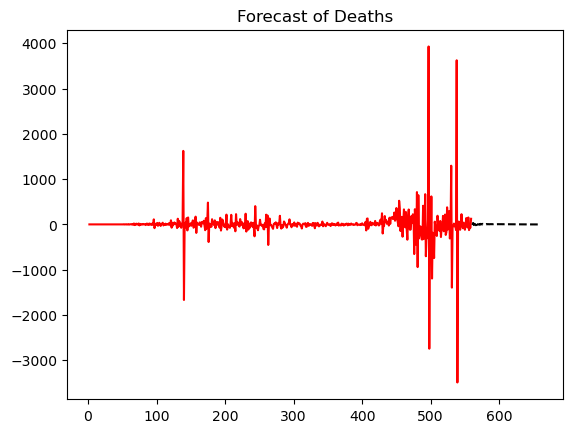

<Figure size 1200x600 with 0 Axes>

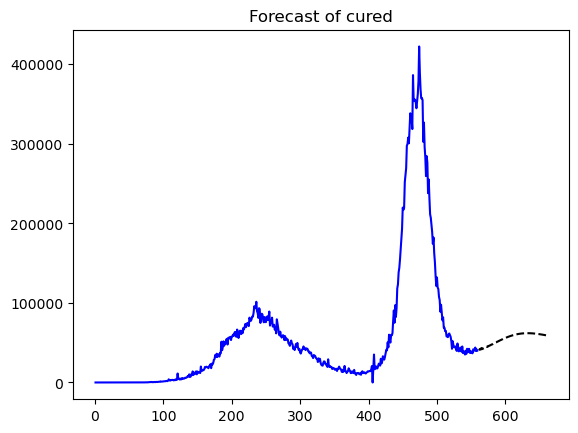

<Figure size 640x480 with 0 Axes>

In [65]:
n_forecast = 100
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))
cured_mean = predict.predicted_mean["cured_tr_1"]
death_mean = predict.predicted_mean["death_tr_2"]

plt.figure(figsize=(12, 6))


fig, ax = plt.subplots()
ax.plot(df2['death_tr_2'], 'red')
ax.plot(idx[-n_forecast:], death_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Deaths')
plt.show()
#**
plt.figure(figsize=(12, 6))


fig, ax = plt.subplots()
ax.plot(df2['cured_tr_1'], 'blue')
ax.plot(idx[-n_forecast:], cured_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of cured')
plt.show()

plt.tight_layout()
